https://nixtlaverse.nixtla.io/statsforecast/docs/models/optimizedtheta.html#model

Optimized theta model

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import scipy.stats as stats
from statsforecast import StatsForecast
from statsforecast.models import OptimizedTheta
from statsmodels.tsa.seasonal import seasonal_decompose
from datasetsforecast.losses import rmse

plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/milk_production.csv", usecols=[1,2])
df.head()

# df['unique_id'] = list(map(str, range(len(df))))
df['unique_id'] = '1'
# statsforecast requires ds, y and unique_id
df.columns = ['ds', 'y', 'unique_id']

print(df.info())

# convert to datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ds         168 non-null    object
 1   y          168 non-null    int64 
 2   unique_id  168 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.1+ KB
None


Visual EDA

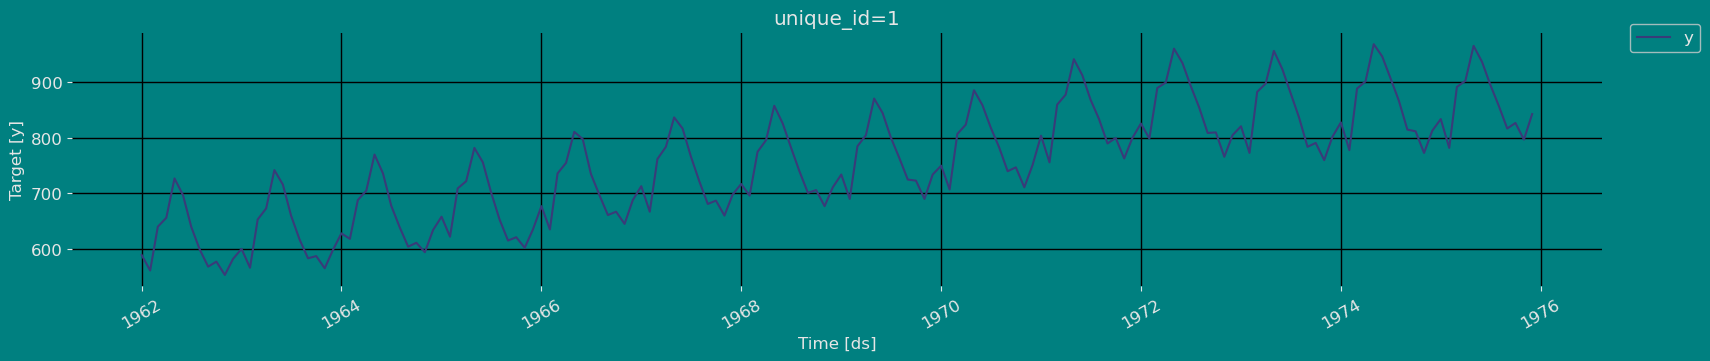

In [3]:
# plots a random series
StatsForecast.plot(df, engine='matplotlib')

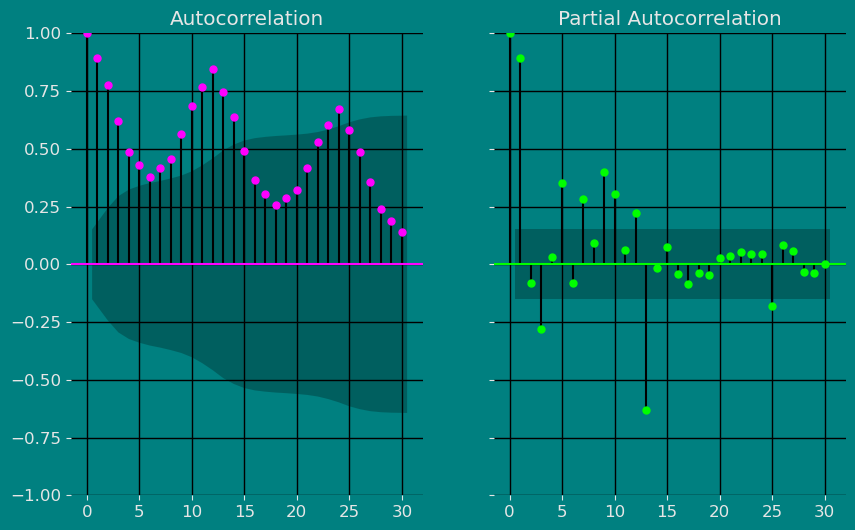

In [4]:
# autocorrelation plot
_, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 6))
plot_acf(df['y'], lags=30, ax=axs[0], color='fuchsia')
plot_pacf(df['y'], lags=30, ax=axs[1], color='lime')
plt.show()

The variation of those components causes the change in the pattern of the time series. These components are:

- Level: This is the primary value that averages over time.
- Trend: The trend is the value that causes increasing or decreasing patterns in a time series.
- Seasonality: This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
- Residual/Noise: These are the random variations in the time series.

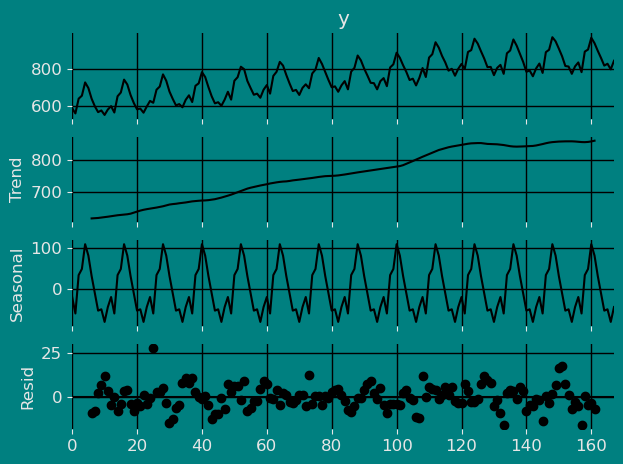

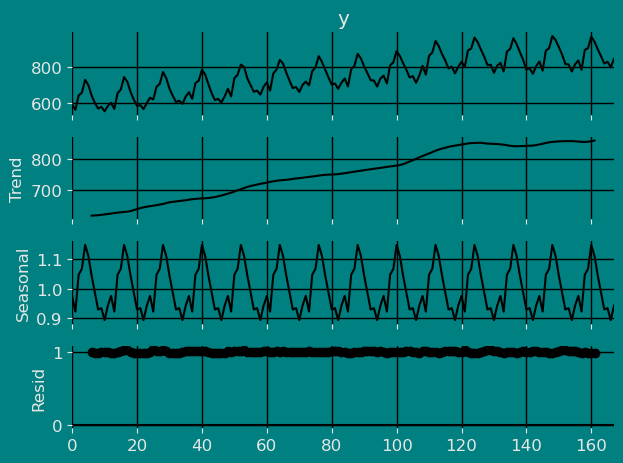

In [5]:
# additive
add = seasonal_decompose(df['y'],
                         model='additive',
                         period=12)

add.plot()
plt.show()

# multiplicative
mul = seasonal_decompose(df['y'],
                         model='multiplicative',
                         period=12)

mul.plot()
plt.show()



Split train test data

(156, 3) (12, 3)


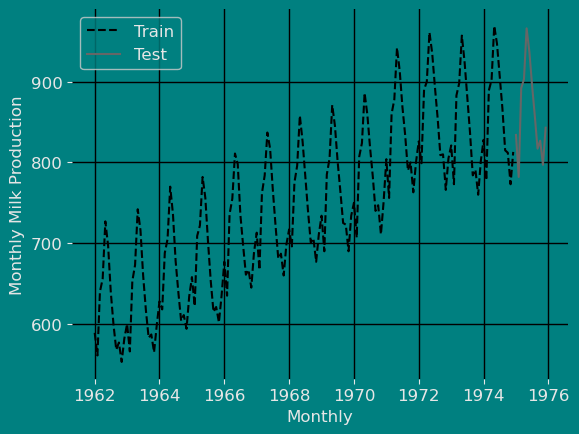

In [6]:
split_date = '1974-12-01'
train = df[df['ds'] <= split_date]
test = df[df['ds'] > split_date]
print(train.shape, test.shape)

# 
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.title("")
plt.ylabel("Monthly Milk Production")
plt.xlabel("Monthly")
plt.show()

Implementation of optimized theta forecasting
- season_length : int
    Number of observations per unit of time. Ex: 24 Hourly data.
- decomposition_type : str
    Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
- alias : str
    Custom name of the model.
- prediction_intervals : Optional[ConformalIntervals]
    Information to compute conformal prediction intervals.
    By default, the model will compute the native prediction
    intervals.

on seasonal period: https://robjhyndman.com/hyndsight/seasonal-periods/

In [7]:
# initiate the model
season_length = 12  # number of months
horizon = len(test)

models = [OptimizedTheta(season_length=season_length,
                         decomposition_type='additive')]

# fit the model
model = StatsForecast(models=models,
                      freq='MS',
                      n_jobs=1)
model.fit(df=df)

StatsForecast(models=[OptimizedTheta])

In [8]:
#  fit results
fit_results = model.fitted_[0, 0].model_
print(fit_results.keys())
print(fit_results['fit'])

resid = pd.DataFrame(fit_results['residuals'], columns=['residual model'])
print(resid)

dict_keys(['mse', 'amse', 'fit', 'residuals', 'm', 'states', 'par', 'n', 'modeltype', 'mean_y', 'decompose', 'decomposition_type', 'seas_forecast', 'fitted'])
results(x=array([-101.34160755,    0.73493683,   29.57558653]), fn=11.012341860669602, nit=63, simplex=array([[-107.56517908,    0.73171752,   27.94381463],
       [-101.34160755,    0.73493683,   29.57558653],
       [ -95.06965984,    0.7339338 ,   24.23812949],
       [-127.40726897,    0.73599938,   27.03055976]]))
     residual model
0       -304.671021
1       -124.146973
2          1.166809
3         40.287964
4        116.693359
..              ...
163       -5.290710
164      -51.100098
165      -43.375977
166      -78.942444
167      -34.997375

[168 rows x 1 columns]


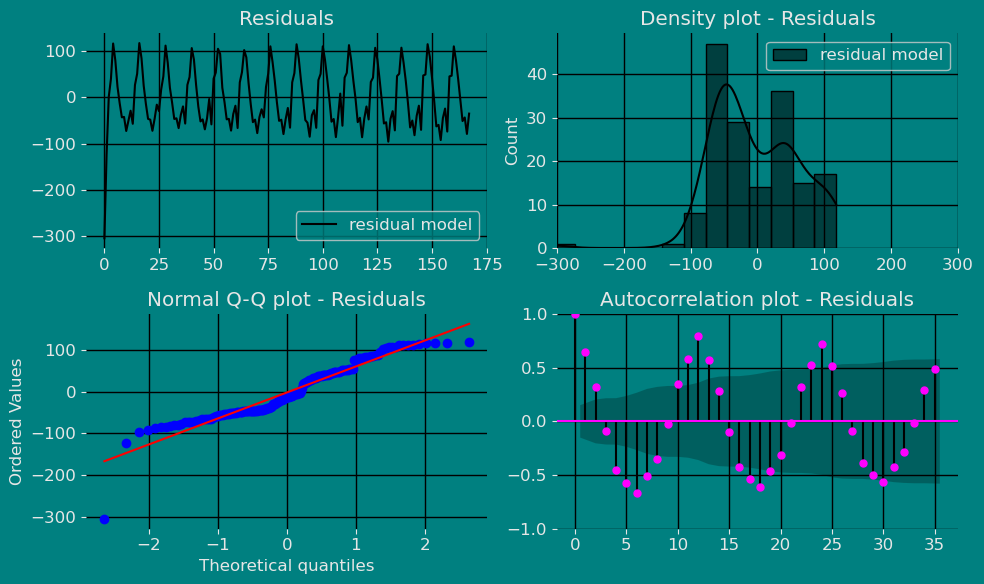

In [9]:
fig, axs = plt.subplots(2, 2,
                        figsize=(10, 6),
                        tight_layout=True)
resid.plot(ax=axs[0, 0])
axs[0, 0].set_title('Residuals')

sns.histplot(resid, ax=axs[0, 1],
             kde=True,)
axs[0, 1].set_xlim(-300, 300)

axs[0, 1].set_title('Density plot - Residuals')

stats.probplot(resid['residual model'],
               dist='norm',
               plot=axs[1, 0])
axs[1, 0].set_title('Normal Q-Q plot - Residuals')

plot_acf(resid, lags=35, ax=axs[1, 1], color='fuchsia')
axs[1, 1].set_title('Autocorrelation plot - Residuals')

plt.show()

Forecasting with .forecast()

The forecast method takes two arguments: forecasts next h (horizon) and level.

- h (int): represents the forecast h steps into the future. In this case, 12 months ahead.

- level (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval

In [10]:
# predictions
y_hat = model.forecast(df=train, h=12, fitted=True)
print(y_hat.head())

# show fitted values
values = model.forecast_fitted_values()
print(values.head())

StatsForecast.plot(values, engine='matplotlib')

# adding a confidence interval
y_hat_ci = model.forecast(df=train, h=horizon, fitted=True, level=[95])
print(y_hat_ci.head())

  unique_id         ds  OptimizedTheta
0         1 1975-01-01      839.682800
1         1 1975-02-01      802.071838
2         1 1975-03-01      896.117126
3         1 1975-04-01      913.193665
4         1 1975-05-01      975.280640
  unique_id         ds      y  OptimizedTheta
0         1 1962-01-01  589.0      860.899414
1         1 1962-02-01  561.0      675.671692
2         1 1962-03-01  640.0      635.231934
3         1 1962-04-01  656.0      614.731323
4         1 1962-05-01  727.0      609.770752
  unique_id         ds  OptimizedTheta  OptimizedTheta-lo-95  \
0         1 1975-01-01      839.682800            742.509583   
1         1 1975-02-01      802.071838            643.581360   
2         1 1975-03-01      896.117126            710.785217   
3         1 1975-04-01      913.193665            736.130981   
4         1 1975-05-01      975.280640            763.057678   

   OptimizedTheta-hi-95  
0            955.414307  
1            945.119263  
2           1065.057495  
3

In [11]:
# merge forecasts with true values
y_hat = y_hat.reset_index()
test['unique_id'].astype(int)
y_hat1 = test.merge(y_hat, how='left', on=['unique_id', 'ds'])

print(y_hat1.head())

          ds    y unique_id  index  OptimizedTheta
0 1975-01-01  834         1      0      839.682800
1 1975-02-01  782         1      1      802.071838
2 1975-03-01  892         1      2      896.117126
3 1975-04-01  903         1      3      913.193665
4 1975-05-01  966         1      4      975.280640


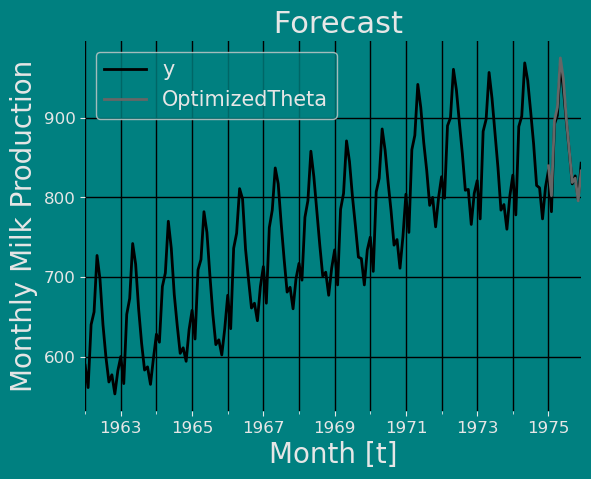

In [12]:
fig, ax = plt.subplots(1, 1)

plot_df = pd.concat([train, y_hat1]).set_index('ds')

plot_df[["y", "OptimizedTheta"]].plot(ax=ax, linewidth=2)

ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly Milk Production', fontsize=20)
ax.set_xlabel('Month [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()

forecasting with .predict()

In [13]:
forecast_df = model.predict(h=horizon, level=[80, 90, 95])
print(forecast_df.columns)
print(forecast_df)


Index(['unique_id', 'ds', 'OptimizedTheta', 'OptimizedTheta-lo-80',
       'OptimizedTheta-hi-80', 'OptimizedTheta-lo-90', 'OptimizedTheta-hi-90',
       'OptimizedTheta-lo-95', 'OptimizedTheta-hi-95'],
      dtype='object')
   unique_id         ds  OptimizedTheta  OptimizedTheta-lo-80  \
0          1 1975-01-01      866.993286            794.367676   
1          1 1975-02-01      828.473083            731.270142   
2          1 1975-03-01      923.898376            789.877747   
3          1 1975-04-01      940.583313            812.038635   
4          1 1975-05-01     1002.745789            871.939270   
5          1 1975-06-01      976.411438            830.747925   
6          1 1975-07-01      928.375183            763.445190   
7          1 1975-08-01      887.781250            706.291809   
8          1 1975-09-01      847.087952            654.134216   
9          1 1975-10-01      852.003662            653.428955   
10         1 1975-11-01      822.884094            605.72418

In [14]:
# plot the forecasts with CI
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(12*10)
    df_plot[['y'] + models].plot(ax=ax, linewidth=3 , )
    colors = ['green', "lime"]
    ax.fill_between(df_plot.index, 
                df_plot['OptimizedTheta-lo-80'], 
                df_plot['OptimizedTheta-lo-80'],
                alpha=.20,
                color='orange',
                label='OptimizedTheta_level_80')
    ax.fill_between(df_plot.index, 
                df_plot['OptimizedTheta-lo-95'], 
                df_plot['OptimizedTheta-hi-95'],
                alpha=.3,
                color='lime',
                label='OptimizedTheta_level_95')
    ax.set_title('', fontsize=22)
    ax.set_ylabel("Montly Mil Production", fontsize=20)
    ax.set_xlabel('Month', fontsize=20)
    ax.legend(prop={'size': 20})
    ax.grid(True)
    plt.show()


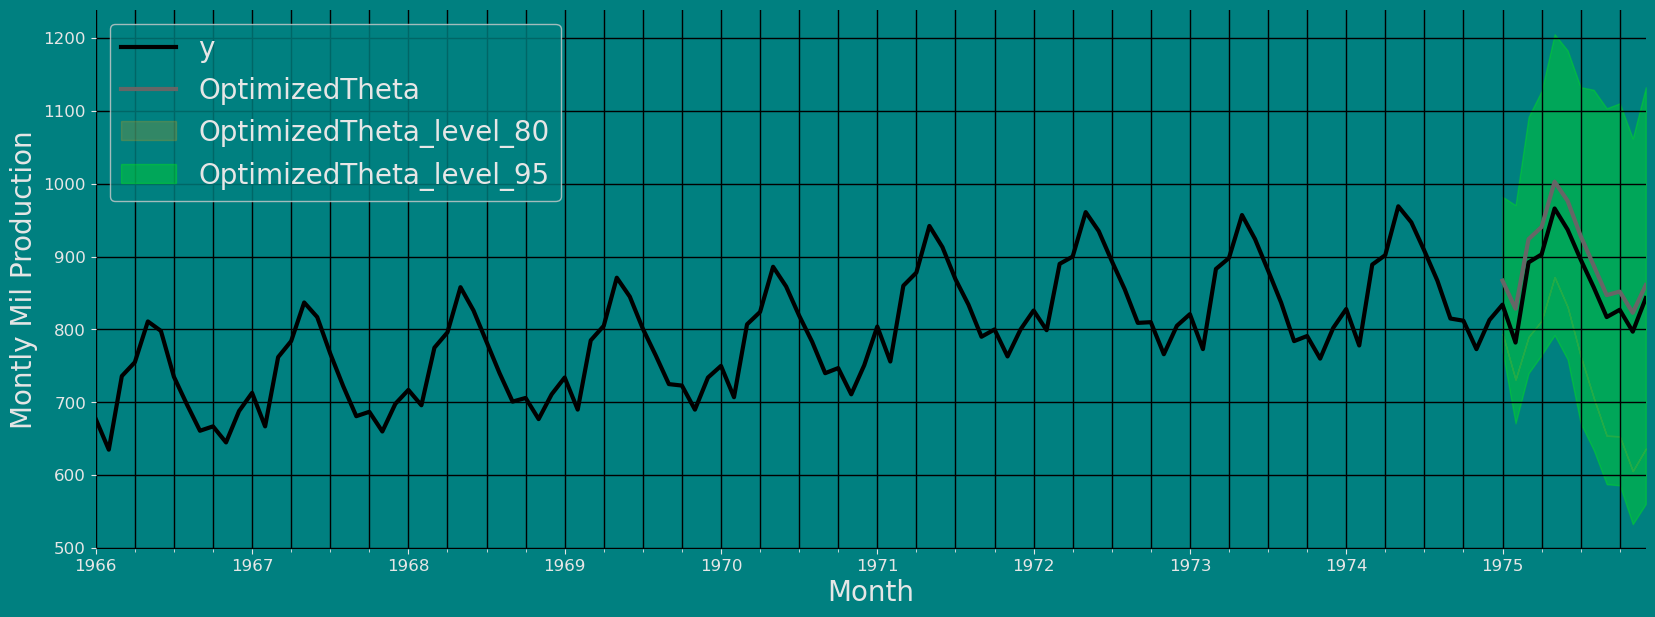

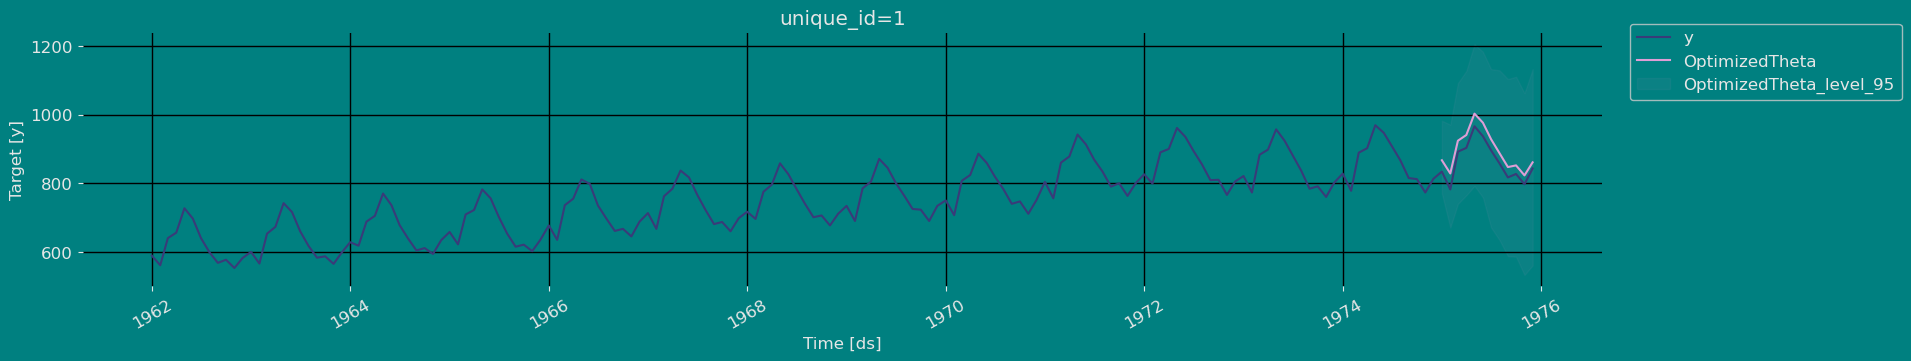

In [15]:
plot_forecasts(train, test, forecast_df, ['OptimizedTheta'])
model.plot(df, forecast_df, level=[95])

Cross validation on historical data
- df: training data frame

- h (int): represents h steps into the future that are being forecasted. In this case, 12 months ahead.

- step_size (int): step size between each window. In other words: how often do you want to run the forecasting processes.

- n_windows(int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [16]:
crossvalidation_df = model.cross_validation(df=train,
                                         h=horizon,
                                         step_size=12,
                                         n_windows=3)

print(crossvalidation_df.head())

  unique_id         ds     cutoff      y  OptimizedTheta
0         1 1972-01-01 1971-12-01  826.0      828.836365
1         1 1972-02-01 1971-12-01  799.0      792.592346
2         1 1972-03-01 1971-12-01  890.0      883.269592
3         1 1972-04-01 1971-12-01  900.0      901.669067
4         1 1972-05-01 1971-12-01  961.0      963.457458


Model evaluation

In [17]:
rmse = rmse(crossvalidation_df['y'], crossvalidation_df['OptimizedTheta'])
print(f'RMSE using cross validation: {rmse}')

RMSE using cross validation: 14.504837036132812
